In [1]:
import fsspec
import xarray as xr
import os
import matplotlib.pyplot as plt
import fv3viz
import pandas as pd
import yaml

from vcm.catalog import catalog

grid = catalog['grid/c48'].read()

In [2]:

seeds = []
for i in range(4):
    rad_results_path = f"gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-06/decrease-rad-lr-rad-flux-seed-{i}/offline_diags/radiative_fluxes/"

    with fsspec.open(os.path.join(rad_results_path, "offline_diagnostics.nc"), "rb") as f:
        rad_diags = xr.open_dataset(f).load()
        
    with fsspec.open(f"gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-06/decrease-rad-lr-rad-flux-seed-{i}/offline_diags/radiative_fluxes/scalar_metrics.json", "r") as f:
        metrics = yaml.safe_load(f)
    
    rad_diags["downward_shortwave_bias"] = (
        rad_diags["downward_shortwave_sfc_flux_via_transmissivity_time_mean_global"].sel(derivation="predict")
        - rad_diags["downward_shortwave_sfc_flux_via_transmissivity_time_mean_global"].sel(derivation="target")
    ) 
    rad_diags["net_sw_bias"] = (
        rad_diags["net_shortwave_sfc_flux_via_transmissivity_time_mean_global"].sel(derivation="predict")
        - rad_diags["net_shortwave_sfc_flux_via_transmissivity_time_mean_global"].sel(derivation="target")
    ) 
    rad_diags["downward_longwave_bias"] = (
        rad_diags["override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface_time_mean_global"].sel(derivation="predict")
        - rad_diags["override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface_time_mean_global"].sel(derivation="target")
    )
    
    rad_diags["downward_shortwave_bias_global_avg"] = metrics["downward_shortwave_sfc_flux_via_transmissivity_bias_2d_global"]["mean"]
    rad_diags["downward_longwave_bias_global_avg"] = metrics["override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface_bias_2d_global"]["mean"]

    seeds.append(rad_diags)
    
ds = xr.concat(seeds, dim=pd.Index(range(4), name="seed"))

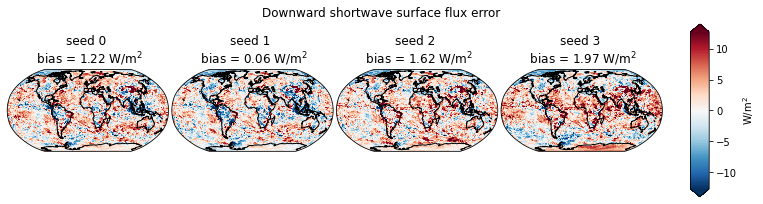

In [10]:
f = fv3viz.plot_cube(
    grid.merge(ds),
    "downward_shortwave_bias", 
    cbar_label="W/m$^2$",
    col="seed"
)
plt.suptitle("Downward shortwave surface flux error")
for i, ax in enumerate(f[-1].axes[0]):
    global_bias = "%0.2f" % ds.isel(seed=i)["downward_shortwave_bias_global_avg"].values.item()
    ax.set_title(f"seed {i} \n bias = {global_bias} W/m$^2$")
#plt.savefig("figures/png/offline_seeds_net_SW_error_map.png", dpi=150)
#plt.savefig("figures/pdf/offline_seeds_net_SW_error_map.pdf", dpi=150)

In [17]:
import numpy as np
np.mean([1.22 , 0.06 , 1.62 , 1.97]), np.std([1.22 , 0.06 , 1.62 , 1.97])

(1.2175, 0.7190401588228574)

Text(0.5, 0.98, 'Downward longwave surface flux error')

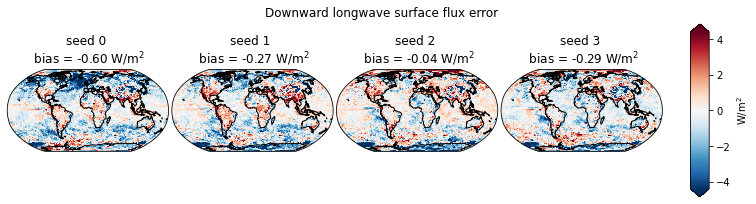

In [11]:
f = fv3viz.plot_cube(
    grid.merge(ds),
    "downward_longwave_bias", 
    cbar_label="W/m$^2$",
    col="seed"
)
for i, ax in enumerate(f[-1].axes[0]):
    global_bias = "%0.2f" % ds.isel(seed=i)["downward_longwave_bias_global_avg"].values.item()
    ax.set_title(f"seed {i} \n bias = {global_bias} W/m$^2$")

plt.suptitle("Downward longwave surface flux error")

In [18]:
np.mean([-.6, -.27, -.04, -.29]), np.std([-.6, -.27, -.04, -.29])

(-0.3, 0.19912307751739877)